In [ ]:
!pip uninstall -y qiskit qiskit-nature pylatexenc rdkit --quiet
!pip install "qiskit==1.4.3" qiskit-nature qiskit-nature-pyscf pylatexenc rdkit --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 11.1 MB/s eta 0:00:00


In [ ]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import NumPyMinimumEigensolver
from rdkit import Chem
from rdkit.Chem import AllChem
import time

In [ ]:
from qiskit_algorithms.utils import algorithm_globals
# Setting random seed to ensure consistent results
algorithm_globals.random_seed = 42

In [ ]:
def compute_molecule_coordinates(sdf_path):
    # Load the molecule from an SDF file
    supplier = Chem.SDMolSupplier(sdf_path, removeHs=False)
    mol = supplier[0]  # First molecule in the file

    if mol is None:
        raise ValueError("Could not read molecule from SDF. Check the file format.")

    # Generate 3D coordinates if not already present
    if not mol.GetConformer().Is3D():
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())
        AllChem.MMFFOptimizeMolecule(mol)

    # Extract coordinates and format them
    conf = mol.GetConformer()
    coords = []

    for i in range(mol.GetNumAtoms()):
        atom = mol.GetAtomWithIdx(i)
        pos = conf.GetAtomPosition(i)
        coords.append(f"{atom.GetSymbol()} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}")

    formatted_coords = "; ".join(coords)

    return formatted_coords


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ligand_1.sdf to ligand_1.sdf


In [ ]:
# O=C(O)CCc1cccc(CO)c1

In [ ]:
# molecule = "H 0 0 0; H 0 0 0.735" # H_2
# molecule = "N 0.000 0.000 0.100; H 0.9377 0.000 -0.270; H -0.46885 0.812 -0.270; H -0.46885 -0.812 -0.270" # NH_3
# molecule = "N 0.000 0.000 0.000; H 0.000 0.000 1.010"

## Load molecule automatically from SDF file that we can download from https://pubchem.ncbi.nlm.nih.gov/

## Eg: Pyrimethamine : https://pubchem.ncbi.nlm.nih.gov/compound/4993
sdf_file = "ligand_1.sdf"
# sdf_file = "Pyrimethamine_Conformer3D_COMPOUND_CID_4993.sdf"
molecule = compute_molecule_coordinates(sdf_file)

print(molecule)

O 4.596800 -0.351900 0.489700; C 3.581600 -1.088600 0.369200; O 3.725000 -2.408800 -0.045800; C 2.217000 -0.532700 0.625600; C 1.620300 0.038400 -0.662800; C 0.244000 0.592600 -0.407600; C 0.081800 1.929900 -0.012700; C -1.192000 2.432300 0.264400; C -2.312300 1.604700 0.155300; C -2.166300 0.266300 -0.240300; C -3.366900 -0.636400 -0.312800; O -3.634800 -1.182700 0.949300; C -0.883300 -0.240000 -0.503200; H 4.641000 -2.795800 -0.239300; H 2.281500 0.264500 1.398600; H 1.563600 -1.342900 1.016700; H 2.281600 0.840700 -1.059100; H 1.566600 -0.758600 -1.437300; H 0.942000 2.580500 0.086400; H -1.310500 3.463500 0.571300; H -3.292400 2.005300 0.383300; H -4.254100 -0.057100 -0.646700; H -3.208800 -1.446000 -1.061600; H -2.960200 -1.896000 1.098600; H -0.761300 -1.280900 -0.779200


In [ ]:
start_time = time.time()

driver = PySCFDriver(
    atom=molecule,
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

print(f"Driver took time: {time.time() - start_time} seconds")

Driver took time: 13.444337606430054 seconds


In [ ]:
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

ast = ActiveSpaceTransformer(2, 2)
es_problem = ast.transform(es_problem)

In [ ]:
mapper = JordanWignerMapper()

In [ ]:
start_time = time.time()

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

end_time = time.time()
print(f"Ansatz took: {end_time - start_time} seconds")

vqe_solver = VQE(Estimator(), ansatz, SLSQP())
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

Ansatz took: 0.01266026496887207 seconds


/tmp/ipython-input-13-3408379144.py:17: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  vqe_solver = VQE(Estimator(), ansatz, SLSQP())


In [ ]:
calc = GroundStateEigensolver(mapper, vqe_solver)

In [ ]:
start_time = time.time()

res = calc.solve(es_problem)

end_time = time.time()

print("""
Selected top 5 ligands:
O=C(O)CCc1cccc(CO)c1 | QED: 0.73 | MW: 180.20
COc1ccc2c(O)cccc2c1 | QED: 0.72 | MW: 174.20
COC1CCc2c(O)cccc2C1 | QED: 0.71 | MW: 178.23
O=C(O)COc1ccccc1 | QED: 0.71 | MW: 152.15
O=C(O)c1cccc(C(=O)O)c1 | QED: 0.69 | MW: 166.13
\n""")
print("Ligand: O=C(O)CCc1cccc(CO)c1 | QED: 0.73\n")
print(res)
print(f"Running time: {end_time - start_time} seconds")


Selected top 5 ligands:
O=C(O)CCc1cccc(CO)c1 | QED: 0.73 | MW: 180.20
COc1ccc2c(O)cccc2c1 | QED: 0.72 | MW: 174.20
COC1CCc2c(O)cccc2C1 | QED: 0.71 | MW: 178.23
O=C(O)COc1ccccc1 | QED: 0.71 | MW: 152.15
O=C(O)c1cccc(C(=O)O)c1 | QED: 0.69 | MW: 166.13


Ligand: O=C(O)CCc1cccc(CO)c1 | QED: 0.73

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -0.871042191872
  - computed part:      -0.871042191872
  - ActiveSpaceTransformer extracted energy part: 0.0
~ Nuclear repulsion energy (Hartree): 739.098911444657
> Total ground state energy (Hartree): 738.227869252784
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [41.43867035  -10.90560946  11.58005272]
 
  0: 
  * Electronic dipole moment (a.u.): [-3.409651212445  3.774015032041  -0.329081922888]
    - computed part:      [-3.409651212445  3.774015032041  -0.329081922888]
    - ActiveSpaceTransformer extracted energy part

### The Hamiltonian

In [ ]:
fermionic_op = es_problem.hamiltonian.second_q_op()
qubit_jw_op = mapper.map(fermionic_op)
print(qubit_jw_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'YYII', 'YYIZ', 'XXII', 'XXIZ', 'ZIII', 'ZIIZ', 'IIYY', 'IZYY', 'IIXX', 'IZXX', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIYY', 'ZIXX', 'IZZI', 'YYZI', 'XXZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.45175644+0.j,  0.07877872+0.j, -0.06826022+0.j,  0.05807464+0.j,
  0.07877872+0.j,  0.08055837+0.j, -0.00092885+0.j, -0.00268752+0.j,
 -0.00092885+0.j, -0.00268752+0.j, -0.06826022+0.j,  0.07820164+0.j,
 -0.00092885+0.j, -0.00268752+0.j, -0.00092885+0.j, -0.00268752+0.j,
  0.02012701+0.j,  0.02012701+0.j,  0.02012701+0.j,  0.02012701+0.j,
 -0.00175935+0.j, -0.00175935+0.j,  0.07820164+0.j, -0.00175935+0.j,
 -0.00175935+0.j,  0.07760852+0.j,  0.05807464+0.j])


### The quantum circuit (the ansatz)

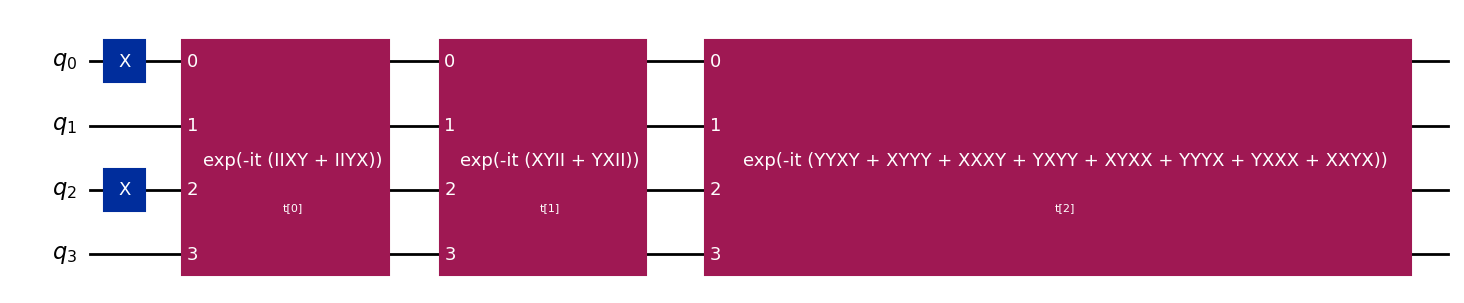

In [ ]:
ansatz.decompose().draw('mpl')